#DATA 410 Lecture 21 - Spring 2022

<font face="Chalkboard" color="darkgreen" size=10>Functional Data Analysis</font>

<font face="Chalkboard" color="darkred" size=8>Generalized Additive Models</font>

We consider a regularized maximum likelihood approach for the generalized additive model

$$\Large
y_i = c +\sum\limits_{j=1}^{p}f_j(x_i^{(j)}) + \epsilon_i
$$

and for standardization we assume 

$$\Large
\sum\limits_{i=1}^{n}f_j(x_i^{(j)})=0
$$

The sparsity-smoothness penalty:

$$\Large
J(f_i) = \lambda_1\sqrt{\|f_j\|^2_n+\lambda_2I^2(f_j)}
$$

where

$$\Large
I^2(f_j)=\int(f''_j(x))^2dx \,\,\, \text{and}\,\,\,\|f\|^2_n=\frac{1}{n}\sum\limits_{i=1}^{n}f_i^2.
$$

The objective function is

$$\Large
\left \|y-\sum\limits_{j=1}^{p}f_j\right\|_n^2 + \sum\limits_{j=1}^{p}J(f_j).
$$

and this is to minimize over a suitable class of functions $\mathcal{F}.$

In [1]:
!pip install csaps

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 120

In [3]:
#! pip install --upgrade statsmodels==0.13.2
# import statsmodels.api as sm

In [4]:
# general imports
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import pyplot

**What we need:** 

- we need the tools, the building blocks for constructing any *nonlinearity* we want. 
- we need a good validation mechanism.
- we need an efficient implementation of such tools in programming languages such as R and Python.

The main idea is to use third degree polynomial functions, such as

$$
s_i(x)=a_i(x-x_i)^3+b_i(x-x_i)^2+c_i(x-x_i)+d_i
$$

for $i=1,2,...,n-1$ and $x_i$ are data points of the same feature. It is quite obvious that we have:


$$
s'_i(x) = 3a_i(x-x_i)^2+2b(x-x_i)+c_i
$$

and 
$$
s''_i(x)=6a_i(x-x_i)+2b_i
$$


So we create 

$$
S(x)= 
\begin{cases}
s_1(x) &\text{if}& x_1\leq x < x_2 \\
s_2(x) &\text{if}& x_2\leq x < x_3 \\
...\\
s_n(x) &\text{if}& x_{n-1}\leq x < x_n 
\end{cases}
$$

We generally want the following *properties* to hold:

1. $S(x)$ is continuous on $[x_1,x_n].$
2. $S'(x)$ is continuous on $[x_1,x_n].$
3. $S''(x)$ is continuous on $[x_1,x_n].$


## Generalized Additive Modeling

The assumption is that 

$$
y_i = \sum\limits_{j=1}^{p}S_j(x_{ij}) +\text{noise}
$$

and of course, ideally, the mean of the noise should be 0; here $p$ is the number of features.

So we get

$$
\mathbb{E}(y_i|x_i) =  \sum\limits_{j=1}^{p}S_j(x_{ij})$$

<font color='blue'>
In this way we can reduce the nonlinear problem to a multiple linear one, however the tradeoff is that we have many more weigths to determine ! 
</font>

This is the reson we need very good methods of regularization and variable selection.


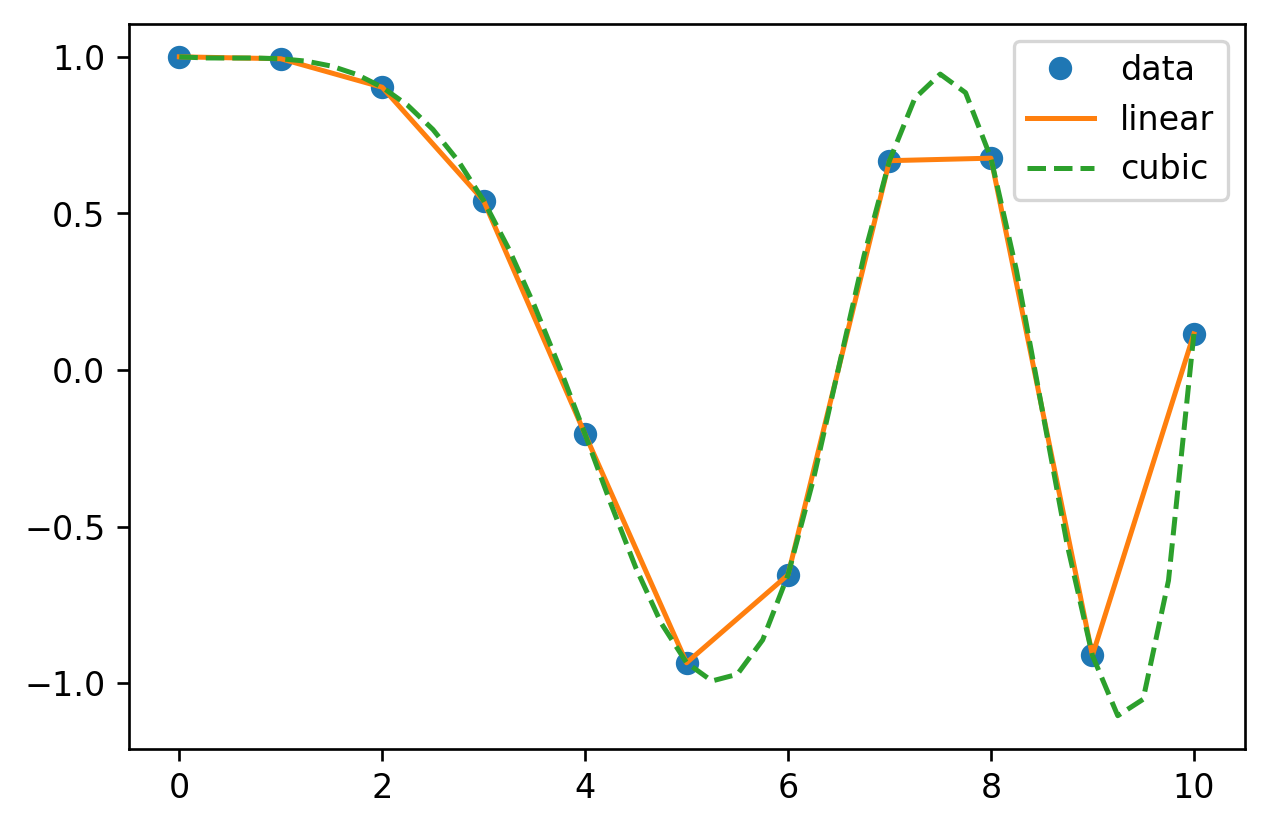

In [5]:
from scipy.interpolate import interp1d

x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xnew = np.linspace(0, 10, num=41, endpoint=True)
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

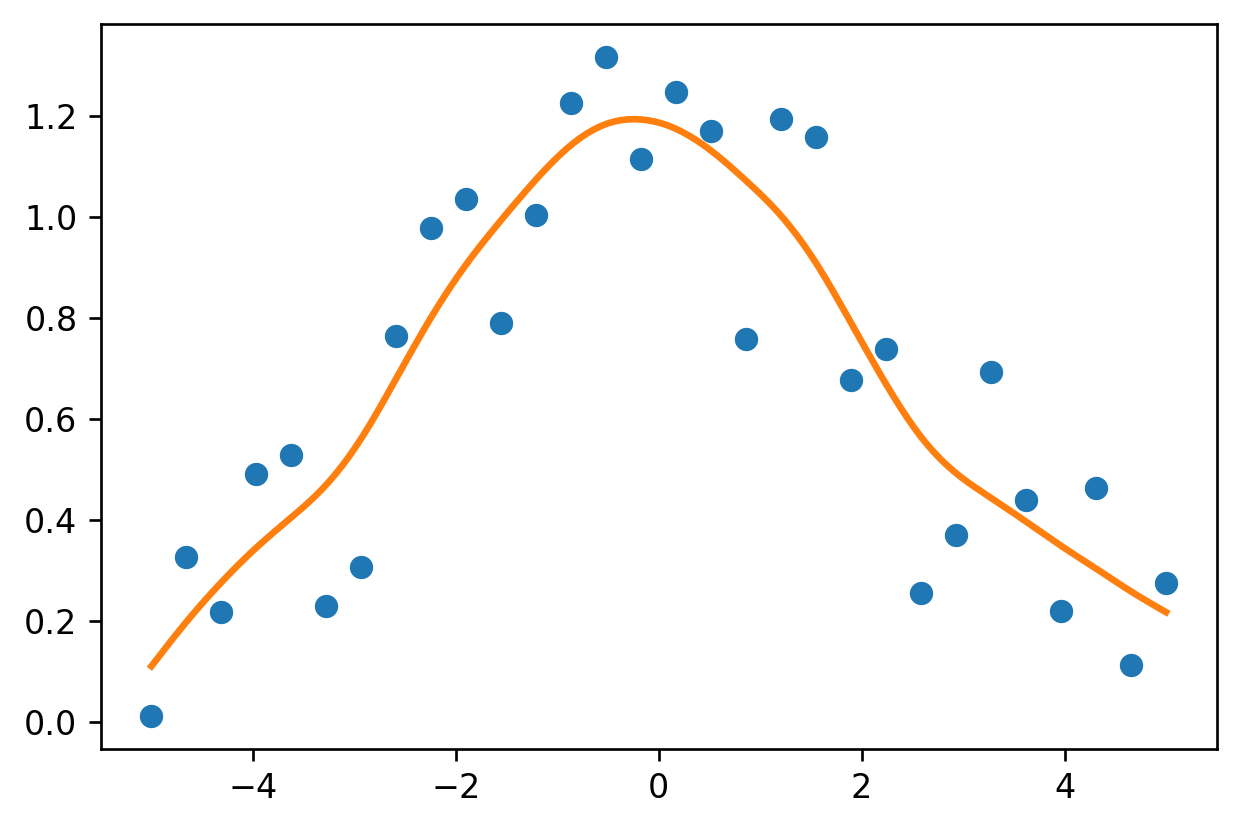

In [9]:
import csaps as cs

np.random.seed(1234)

x = np.linspace(-5., 5., 30)
y = np.exp(-(x/2.5)**2) + (np.random.rand(30) - 0.2) * 0.7

sp = cs.CubicSmoothingSpline(x, y, smooth=0.75)

xs = np.linspace(x[0], x[-1], 150)
ys = sp(xs)

plt.plot(x, y, 'o', xs, ys, '-',lw=2)
plt.show()

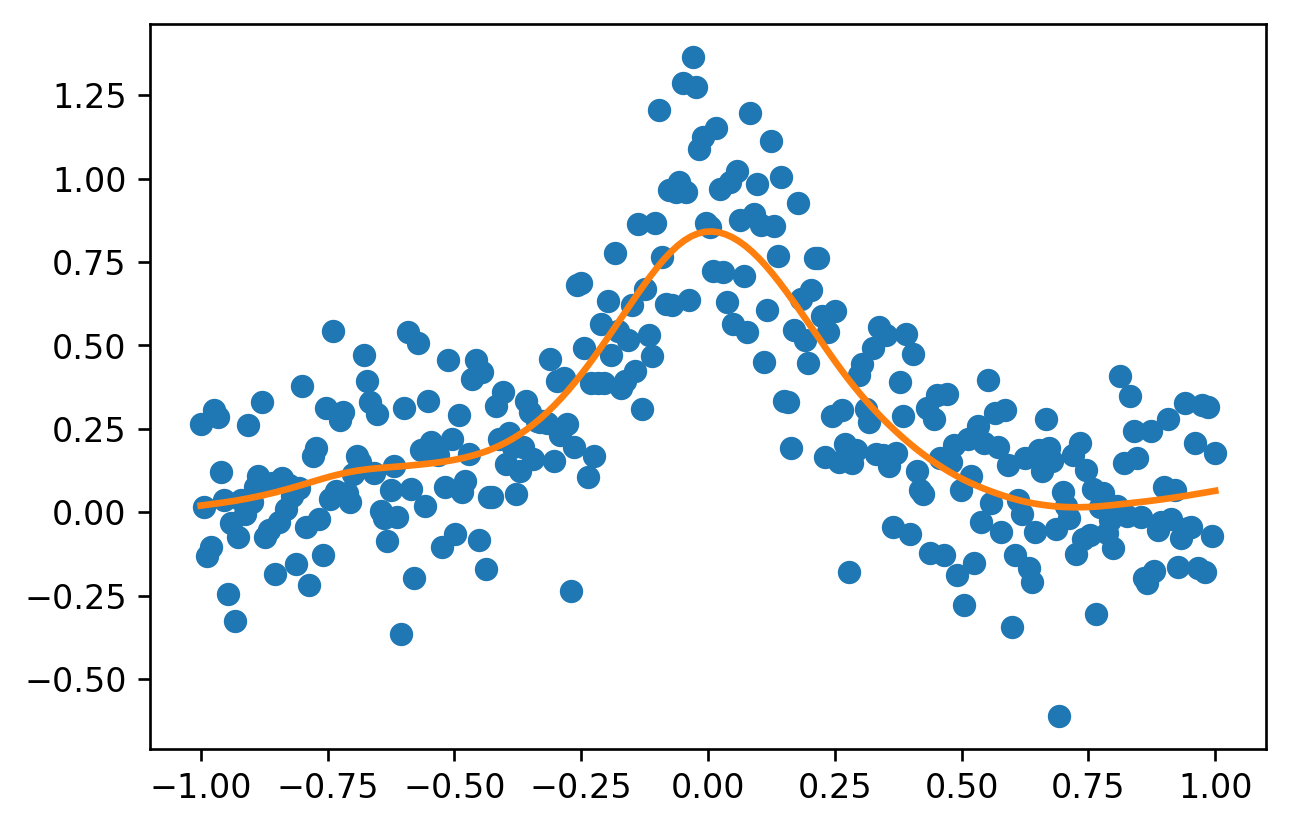

In [21]:
def func(x):
    return 1/(1+25*x**2)

# make example data
x = np.linspace(-1,1,300)
y = func(x) + np.random.normal(0, 0.2, len(x))

sp = cs.CubicSmoothingSpline(x, y, smooth=0.99)

xs = np.linspace(x[0], x[-1], 150)
ys = sp(xs)

plt.plot(x, y, 'o', xs, ys, '-',lw=2)
plt.show()

## Typically we need about $\sqrt{n}-4$ knots for the smoothing splines

In [11]:
np.sqrt(200)-4

10.142135623730951

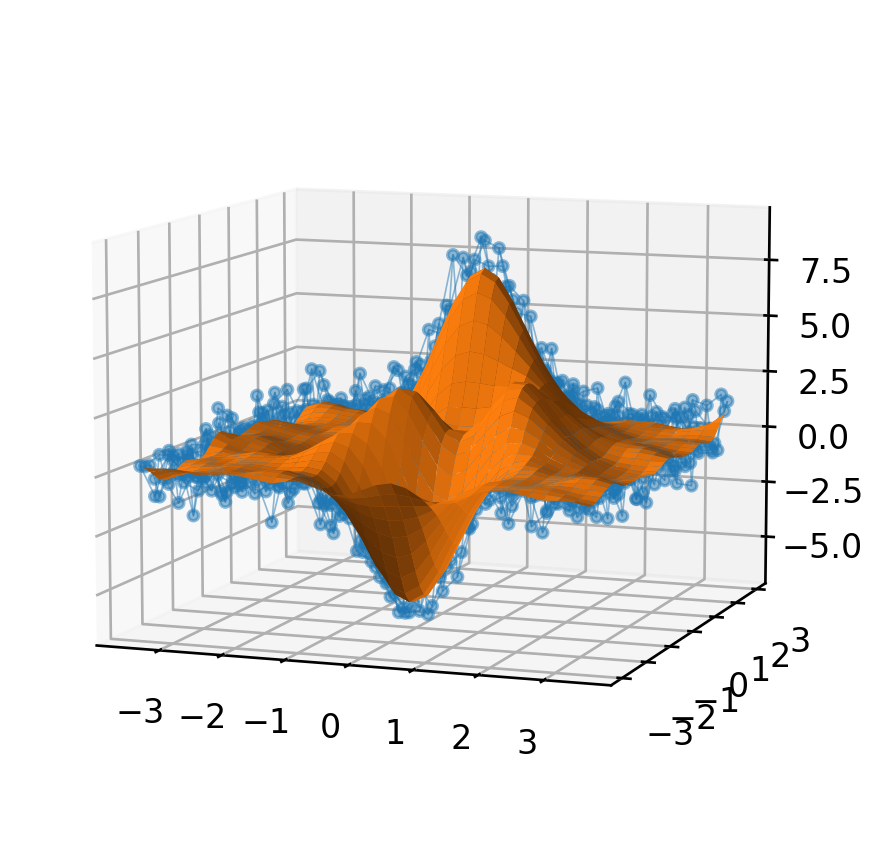

In [12]:
from csaps import csaps
np.random.seed(1234)
xdata = [np.linspace(-3, 3, 41), np.linspace(-3.5, 3.5, 31)]
i, j = np.meshgrid(*xdata, indexing='ij')
ydata = (3 * (1 - j)**2. * np.exp(-(j**2) - (i + 1)**2)
         - 10 * (j / 5 - j**3 - i**5) * np.exp(-j**2 - i**2)
         - 1 / 3 * np.exp(-(j + 1)**2 - i**2))
ydata = ydata + (np.random.randn(*ydata.shape) * 0.75)

ydata_s = csaps(xdata, ydata, xdata, smooth=0.988)

fig = plt.figure(figsize=(7, 4.5))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('none')
c = [s['color'] for s in plt.rcParams['axes.prop_cycle']]
ax.plot_wireframe(j, i, ydata, linewidths=0.5, color=c[0], alpha=0.5)
ax.scatter(j, i, ydata, s=10, c=c[0], alpha=0.5)
ax.plot_surface(j, i, ydata_s, color=c[1], linewidth=0, alpha=1.0)
ax.view_init(elev=9., azim=290)

plt.show()

## The Anatomy of Splines

Splines are third degree polynomial functions, such as

$$
s_i(x)=a_i(x-x_i)^3+b_i(x-x_i)^2+c_i(x-x_i)+d_i
$$

for $i=1,2,...,n-1$ and $x_i$ are data points of the same feature. It is quite obvious that we have:
$$
s'_i(x) = 3a_i(x-x_i)^2+2b(x-x_i)+c_i
$$

and 
$$
s''_i(x)=6a_i(x-x_i)+2b_i
$$


So we create 

$$
S(x)= 
\begin{cases}
s_1(x) &\text{if}& x_1\leq x < x_2 \\
s_2(x) &\text{if}& x_2\leq x < x_3 \\
...\\
s_n(x) &\text{if}& x_n-1\leq x < x_n 
\end{cases}
$$

We generally want the following *properties* to hold:

1. $S(x)$ is continuous on $[x_1,x_n].$
2. $S'(x)$ is continuous on $[x_1,x_n].$
3. $S''(x)$ is continuous on $[x_1,x_n].$

And of course, we want to interpolate some data points:

$$
S(x_i)=y_i
$$

and that is to say that 

$$
y_i= d_i.
$$

In order to make the curve smooth across the interval, the derivatives must be equal at the *stitching* points:

$$
s'_i(x_i) = s'_{i-1}(x_i).
$$

Let $M_i:=2b_i$ and $h=x_{i+1}-x_i$. After some tedious calculation we get the following matrix equation:

<figure>
<center>
<img src='https://drive.google.com/uc?id=1JrWAp1LgtR_5BLNDL1TK57QY_cGSDNic' 
width='700px' />
<figcaption>Difference between L1 and L2</figcaption></center>
</figure>

which linear system has $n-2$ rows and $n$ columns, so it is underdetermined. Imposing some extra conditions, we can solve the system.

One easy condition is $M_1=M_n=0$ and what we get is referred to as **Natural Splines**.

Typically we only need about $\sqrt{n}-4$ knots

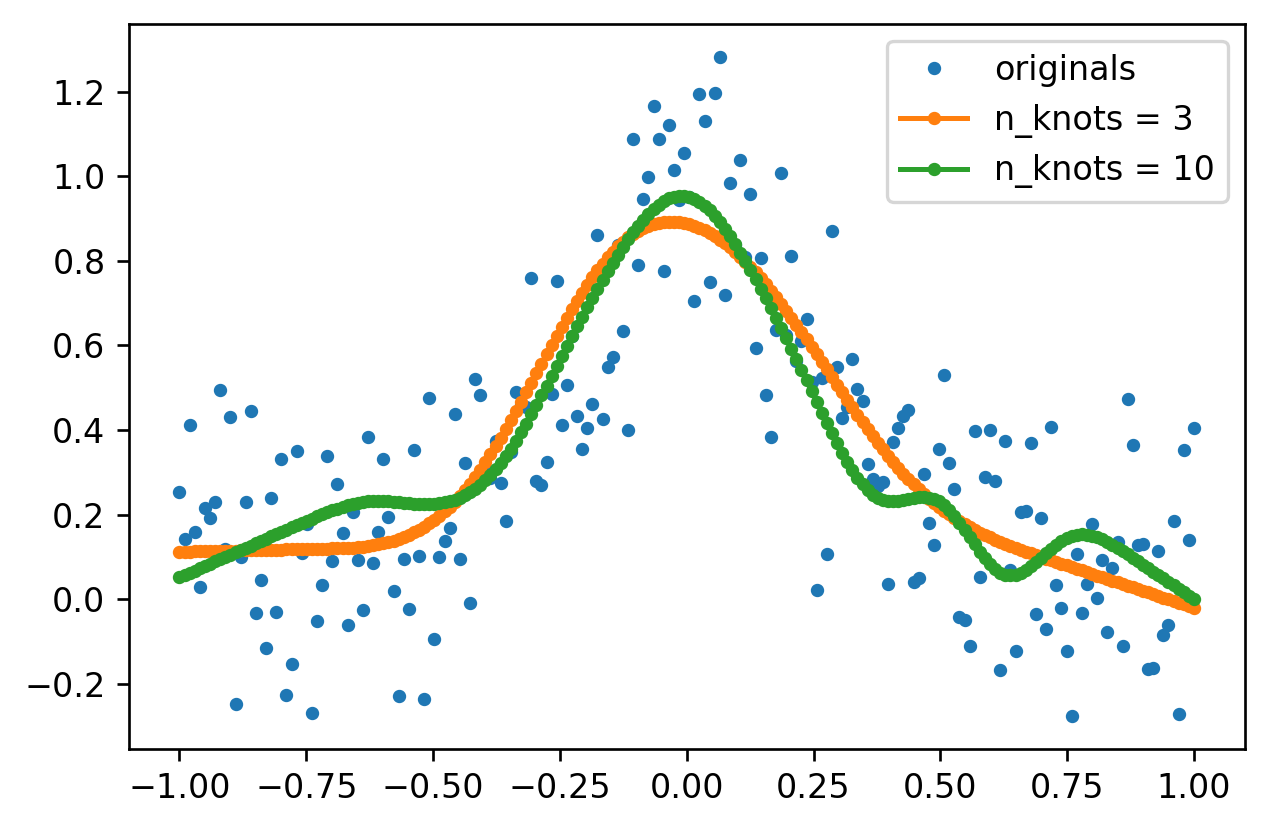

In [ ]:
def func(x):
    return 1/(1+16*x**2)

# make example data
x = np.linspace(-1,1,200)
y = func(x) + np.random.normal(0, 0.2, len(x))

# The number of knots can be used to control the amount of smoothness
model_3 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=3)
model_10 = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=10)
y_est_6 = model_6.predict(x)
y_est_15 = model_15.predict(x)


plt.plot(x, y, ls='', marker='.', label='originals')
plt.plot(x, y_est_6, marker='.', label='n_knots = 3')
plt.plot(x, y_est_15, marker='.', label='n_knots = 10')
plt.legend(); 
plt.savefig('fig1.png',dpi=300)
plt.show()

## Message: the number of knots is a hyperparameter !!

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

## Real Data applications of the GAM

In [ ]:
df = pd.read_csv('drive/MyDrive/Data Sets/Boston Housing Prices.csv')
features = ['crime','rooms','residential','industrial','nox','older','distance','highway','tax','ptratio','lstat']
X = np.array(df[features])
y = np.array(df['cmedv']).reshape(-1,1)
Xdf = df[features]

In [ ]:
Xdf

,crime,rooms,residential,industrial,nox,older,distance,highway,tax,ptratio,lstat
0,0.00632,6.575,18.0,2.31,0.538,65.199997,4.0900,1,296,15.300000,4.98
1,0.02731,6.421,0.0,7.07,0.469,78.900002,4.9671,2,242,17.799999,9.14
2,0.02729,7.185,0.0,7.07,0.469,61.099998,4.9671,2,242,17.799999,4.03
3,0.03237,6.998,0.0,2.18,0.458,45.799999,6.0622,3,222,18.700001,2.94
4,0.06905,7.147,0.0,2.18,0.458,54.200001,6.0622,3,222,18.700001,5.33
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,6.593,0.0,11.93,0.573,69.099998,2.4786,1,273,21.000000,9.67
502,0.04527,6.120,0.0,11.93,0.573,76.699997,2.2875,1,273,21.000000,9.08
503,0.06076,6.976,0.0,11.93,0.573,91.000000,2.1675,1,273,21.000000,5.64
504,0.10959,6.794,0.0,11.93,0.573,89.300003,2.3889,1,273,21.000000,6.48


In [ ]:
Xdf.shape

(506, 11)

In [ ]:
!pip install pygam

In [ ]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold

In [ ]:
Xs_train = scale.fit_transform(X_train)
Xs_test =scale.transform(X_test)

In [ ]:
gam = LinearGAM(n_splines=5).gridsearch(Xs_train, y_train,objective='GCV')
gam.summary()

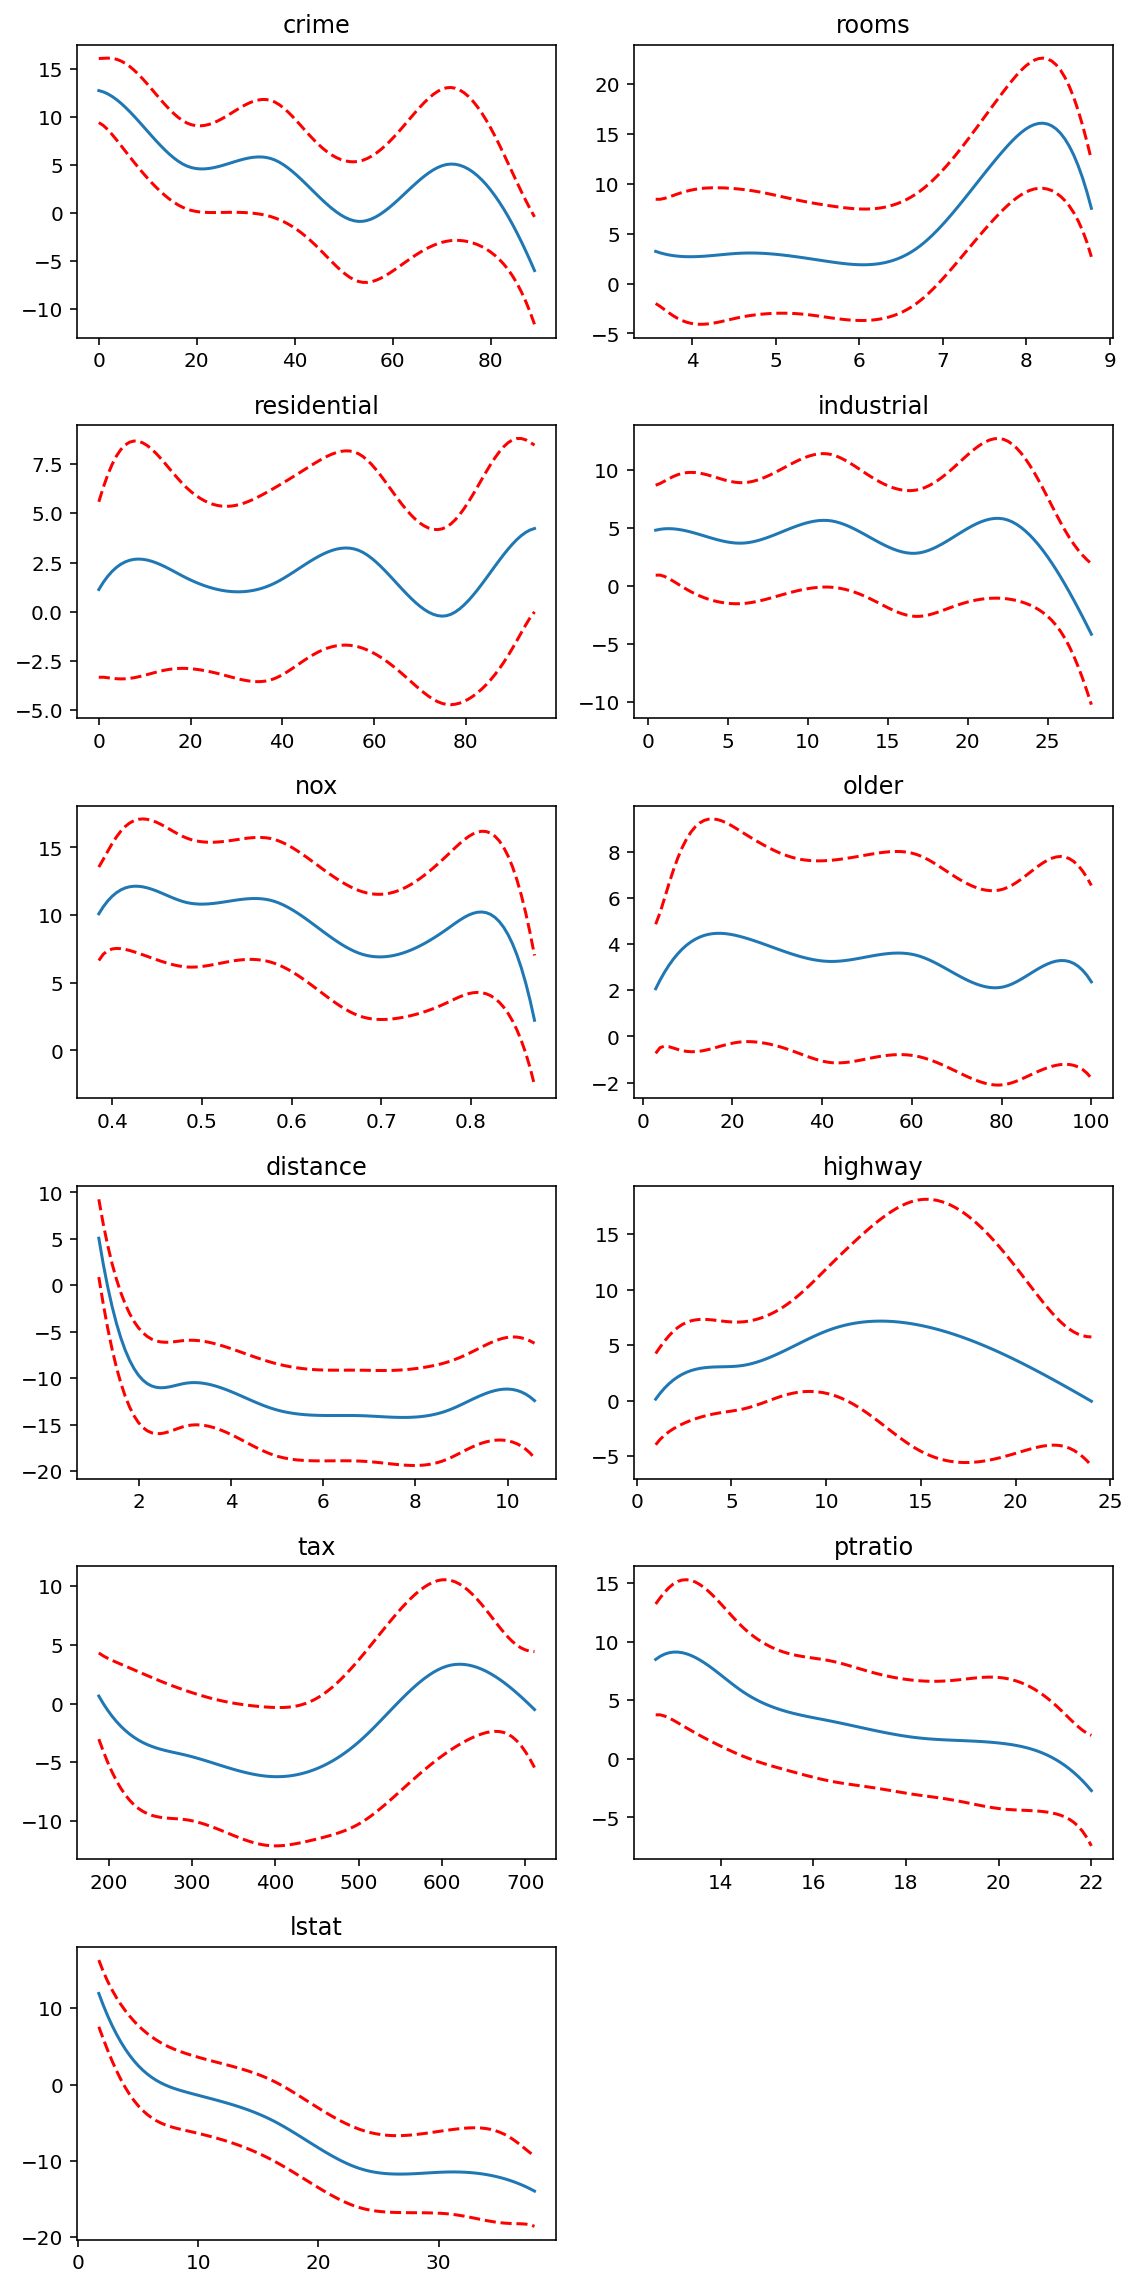

In [ ]:
plt.rcParams['figure.figsize'] = (28, 8)
fig = plt.figure()
titles = df[features].columns

fig.set_figheight(16)
fig.set_figwidth(8)

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = lingam.generate_X_grid(term=i)
    pdep, confi = lingam.partial_dependence(term=i, X=XX, width=0.95)
    ax = fig.add_subplot(6, 2, i+1)
    ax.plot(XX[:, term.feature], pdep)
    ax.plot(XX[:, term.feature], confi, c='r', ls='--')
    ax.set_title(titles[i])
    fig.tight_layout()
plt.show()